In [18]:
import json
import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
%matplotlib inline

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')

LOG_DIR = Path('../logs')
SUMMARY_CSV = Path('logs/training_summary.csv')

print(f'[INFO] Will read training runs from: {LOG_DIR.resolve()}')


[INFO] Will read training runs from: /Users/karanpatel/Downloads/Topics In CS/Assignmnet_1/logs


In [20]:
def load_json_file(path: Path):
    """
    Load JSON file containing episode data and summary statistics.
    Returns dict with 'episodes' list and summary info, or None if unreadable.
    """
    try:
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        # Check if it has the expected structure
        if isinstance(data, dict) and 'episodes' in data:
            return data
        elif isinstance(data, list):  # Fallback for list format
            return {'episodes': data}
    except Exception as e:
        print(f"[WARN] failed to load {path}: {e}")
    return None

def to_array(episodes, key):
    """
    Extract numeric series for a given key from the list of per-episode dicts.
    Missing/invalid -> np.nan.
    """
    vals = []
    for d in episodes:
        if key in d:
            try:
                vals.append(float(d[key]))
            except Exception:
                vals.append(np.nan)
        else:
            vals.append(np.nan)
    return np.array(vals, dtype=float)
def safe_masked_pair(x, y):
    """
    Keep only pairs where both x and y are finite, so plots don't break.
    """
    mask = np.isfinite(x) & np.isfinite(y)
    return x[mask], y[mask]


def rolling_average(data, window=10):
    """
    Compute rolling average for smoother visualization.
    """
    if len(data) < window:
        return data
    return np.convolve(data, np.ones(window)/window, mode='valid')


def summarize_run(name, data):
    """
    Produce summary stats for one run (one JSON file).
    """
    episodes = data.get('episodes', [])
    
    # Extract arrays
    rew = to_array(episodes, 'episode_reward')
    length = to_array(episodes, 'episode_length')
    
    # Optional metrics
    lines = to_array(episodes, 'lines') if any('lines' in d for d in episodes) else np.array([])
    hard_drops = to_array(episodes, 'hard_drops') if any('hard_drops' in d for d in episodes) else np.array([])
    soft_drops = to_array(episodes, 'soft_drops') if any('soft_drops' in d for d in episodes) else np.array([])
    rotations = to_array(episodes, 'rotations') if any('rotations' in d for d in episodes) else np.array([])
    
    summary = {
        'run': name,
        'algorithm': data.get('algorithm', 'unknown'),
        'persona': data.get('persona', 'unknown'),
        'total_episodes': data.get('total_episodes', len(episodes)),
        'total_timesteps': data.get('total_timesteps', 0),
        'reward_mean': float(np.nanmean(rew)) if rew.size else np.nan,
        'reward_std': float(np.nanstd(rew)) if rew.size else np.nan,
        'reward_min': float(np.nanmin(rew)) if rew.size else np.nan,
        'reward_max': float(np.nanmax(rew)) if rew.size else np.nan,
        'length_mean': float(np.nanmean(length)) if length.size else np.nan,
        'length_std': float(np.nanstd(length)) if length.size else np.nan,
        'length_max': float(np.nanmax(length)) if length.size else np.nan,
        'lines_mean': float(np.nanmean(lines)) if lines.size else np.nan,
        'lines_max': float(np.nanmax(lines)) if lines.size else np.nan,
        'hard_drops_mean': float(np.nanmean(hard_drops)) if hard_drops.size else np.nan,
        'soft_drops_mean': float(np.nanmean(soft_drops)) if soft_drops.size else np.nan,
        'rotations_mean': float(np.nanmean(rotations)) if rotations.size else np.nan,
    }
    return summary


In [21]:

def plot_reward_curves(runs_dict, use_rolling=True, window=50):
    """Plot reward vs episode for each run on the same axes."""
    plt.figure(figsize=(12, 6))
    
    for run_name, data in runs_dict.items():
        episodes = data.get('episodes', [])
        
        # Extract data
        ep_nums = list(range(len(episodes)))
        rew = [ep.get('episode_reward', 0) for ep in episodes]
        
        # Downsample if too many points (keeps every Nth point)
        if len(ep_nums) > 1000:
            step = len(ep_nums) // 1000
            ep_nums = ep_nums[::step]
            rew = rew[::step]
        
        if len(ep_nums) > 0:
            if use_rolling and len(rew) >= window:
                rew_smooth = rolling_average(rew, window)
                ep_smooth = ep_nums[window-1:]
                plt.plot(ep_smooth, rew_smooth, label=run_name, linewidth=2, linestyle='-')
            else:
                plt.plot(ep_nums, rew, label=run_name, linewidth=2, linestyle='-', alpha=0.7)
    
    plt.title('Episode Reward Over Training (All Runs)', fontsize=14, fontweight='bold')
    plt.xlabel('Episode Number', fontsize=12)
    plt.ylabel('Reward', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()


def plot_length_curves(runs_dict, use_rolling=True, window=50):
    """Plot episode length vs episode for each run."""
    plt.figure(figsize=(12, 6))
    
    for run_name, data in runs_dict.items():
        episodes = data.get('episodes', [])
        
        # Extract data
        ep_nums = list(range(len(episodes)))
        lng = [ep.get('episode_length', 0) for ep in episodes]
        
        # Downsample if too many points
        if len(ep_nums) > 1000:
            step = len(ep_nums) // 1000
            ep_nums = ep_nums[::step]
            lng = lng[::step]
        
        if len(ep_nums) > 0:
            if use_rolling and len(lng) >= window:
                lng_smooth = rolling_average(lng, window)
                ep_smooth = ep_nums[window-1:]
                plt.plot(ep_smooth, lng_smooth, label=run_name, linewidth=2, linestyle='-')
            else:
                plt.plot(ep_nums, lng, label=run_name, linewidth=2, linestyle='-', alpha=0.7)
    
    plt.title('Episode Length Over Training (All Runs)', fontsize=14, fontweight='bold')
    plt.xlabel('Episode Number', fontsize=12)
    plt.ylabel('Episode Length (steps)', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()


def plot_algorithm_comparison(runs_dict, downsample=True):
    """Create side-by-side comparison of PPO vs A2C performance."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Group by algorithm
    ppo_runs = {k: v for k, v in runs_dict.items() if 'ppo' in k.lower()}
    a2c_runs = {k: v for k, v in runs_dict.items() if 'a2c' in k.lower()}
    
    # Plot rewards for PPO
    for run_name, data in ppo_runs.items():
        episodes = data.get('episodes', [])
        ep_nums = list(range(len(episodes)))
        rew = [ep.get('episode_reward', 0) for ep in episodes]
        
        if downsample and len(ep_nums) > 1000:
            step = len(ep_nums) // 1000
            ep_nums = ep_nums[::step]
            rew = rew[::step]
        
        if len(ep_nums) > 0:
            axes[0].plot(ep_nums, rew, label=run_name, linewidth=2, linestyle='-')
    
    # Plot rewards for A2C
    for run_name, data in a2c_runs.items():
        episodes = data.get('episodes', [])
        ep_nums = list(range(len(episodes)))
        rew = [ep.get('episode_reward', 0) for ep in episodes]
        
        if downsample and len(ep_nums) > 1000:
            step = len(ep_nums) // 1000
            ep_nums = ep_nums[::step]
            rew = rew[::step]
        
        if len(ep_nums) > 0:
            axes[1].plot(ep_nums, rew, label=run_name, linewidth=2, linestyle='-')
    
    axes[0].set_title('PPO Reward Curves', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Episode Number')
    axes[0].set_ylabel('Reward')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, linestyle='--')
    
    axes[1].set_title('A2C Reward Curves', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Episode Number')
    axes[1].set_ylabel('Reward')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()


def plot_persona_comparison(runs_dict, downsample=True):
    """Create side-by-side comparison of Survivor vs Explorer personas."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Group by persona
    survivor_runs = {k: v for k, v in runs_dict.items() if 'survivor' in k.lower()}
    explorer_runs = {k: v for k, v in runs_dict.items() if 'explorer' in k.lower()}
    
    # Plot rewards for Survivor
    for run_name, data in survivor_runs.items():
        episodes = data.get('episodes', [])
        ep_nums = list(range(len(episodes)))
        rew = [ep.get('episode_reward', 0) for ep in episodes]
        
        if downsample and len(ep_nums) > 1000:
            step = len(ep_nums) // 1000
            ep_nums = ep_nums[::step]
            rew = rew[::step]
        
        if len(ep_nums) > 0:
            axes[0].plot(ep_nums, rew, label=run_name, linewidth=2, linestyle='-')
    
    # Plot rewards for Explorer
    for run_name, data in explorer_runs.items():
        episodes = data.get('episodes', [])
        ep_nums = list(range(len(episodes)))
        rew = [ep.get('episode_reward', 0) for ep in episodes]
        
        if downsample and len(ep_nums) > 1000:
            step = len(ep_nums) // 1000
            ep_nums = ep_nums[::step]
            rew = rew[::step]
        
        if len(ep_nums) > 0:
            axes[1].plot(ep_nums, rew, label=run_name, linewidth=2, linestyle='-')
    
    axes[0].set_title('Survivor Persona Reward Curves', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Episode Number')
    axes[0].set_ylabel('Reward')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, linestyle='--')
    
    axes[1].set_title('Explorer Persona Reward Curves', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Episode Number')
    axes[1].set_ylabel('Reward')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

In [22]:
runs = {}
for path_str in glob.glob(str(LOG_DIR / '*_episodes.json')):
    p = Path(path_str)
    data = load_json_file(p)
    if data:
        # Use a cleaner name (remove '_episodes' suffix)
        run_name = p.stem.replace('_episodes', '')
        runs[run_name] = data

print(f"[INFO] Loaded {len(runs)} runs:", list(runs.keys()))
if not runs:
    print("[WARN] No training data found. Make sure you've run training first.")
    print(f"       Looking for files matching: {LOG_DIR / '*_episodes.json'}")



[INFO] Loaded 4 runs: ['a2c_survivor', 'ppo_survivor', 'a2c_explorer', 'ppo_explorer']


In [23]:
summaries = [summarize_run(name, data) for name, data in runs.items()]
df_summary = pd.DataFrame(summaries)

if len(df_summary) > 0:
    # Sort by algorithm and persona
    df_summary = df_summary.sort_values(['algorithm', 'persona'])
    
    # Display summary
    display(df_summary)
    
    # Create logs directory if it doesn't exist
    SUMMARY_CSV.parent.mkdir(parents=True, exist_ok=True)
    
    # Save to CSV
    df_summary.to_csv(SUMMARY_CSV, index=False)
    print(f'\n[OK] Wrote summary CSV -> {SUMMARY_CSV.resolve()}')
else:
    print('[WARN] No data to summarize')

,run,algorithm,persona,total_episodes,total_timesteps,reward_mean,reward_std,reward_min,reward_max,length_mean,length_std,length_max,lines_mean,lines_max,hard_drops_mean,soft_drops_mean,rotations_mean
2,a2c_explorer,a2c,explorer,96558,5120,49.810704,26.797029,18.0,180.0,24.905352,13.398514,90.0,NaN,NaN,NaN,NaN,NaN
0,a2c_survivor,a2c,survivor,96558,5120,12.452676,6.699257,4.5,45.0,24.905352,13.398514,90.0,NaN,NaN,NaN,NaN,NaN
3,ppo_explorer,ppo,explorer,89937,5120,67.004748,44.114372,20.0,310.0,33.502374,22.057186,155.0,NaN,NaN,NaN,NaN,NaN
1,ppo_survivor,ppo,survivor,88814,5120,17.065688,11.311083,5.0,84.5,34.131376,22.622165,169.0,NaN,NaN,NaN,NaN,NaN



[OK] Wrote summary CSV -> /Users/karanpatel/Downloads/Topics In CS/Assignmnet_1/notebooks/logs/training_summary.csv


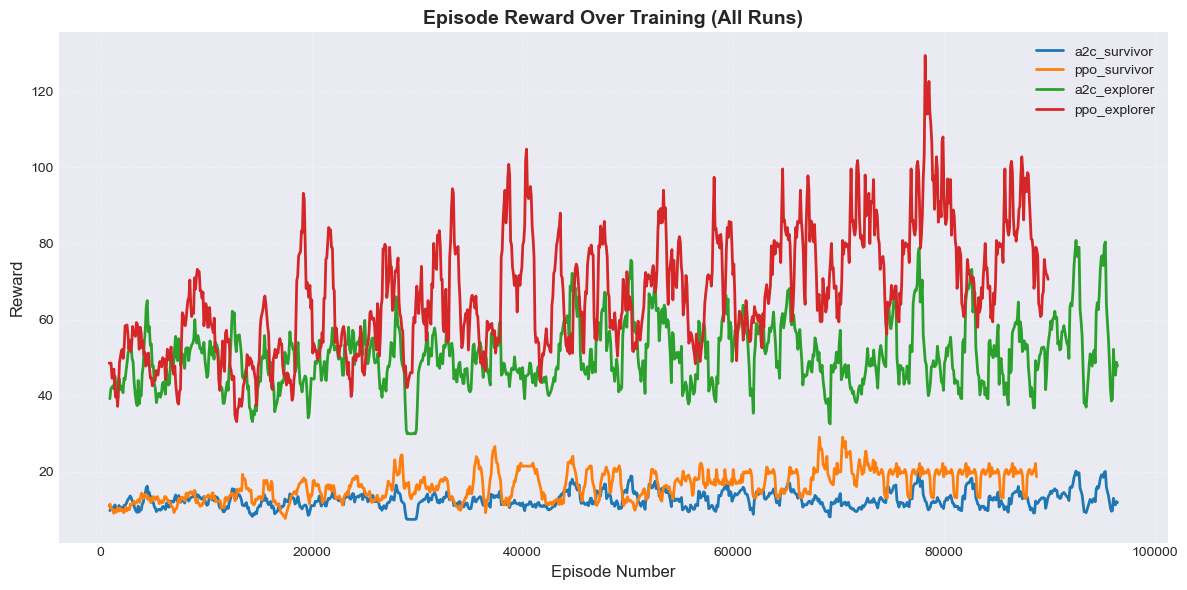

In [29]:
if runs:
    plot_reward_curves(runs, use_rolling=True, window=10)
else:
    print('[WARN] Nothing to plot for reward curves')



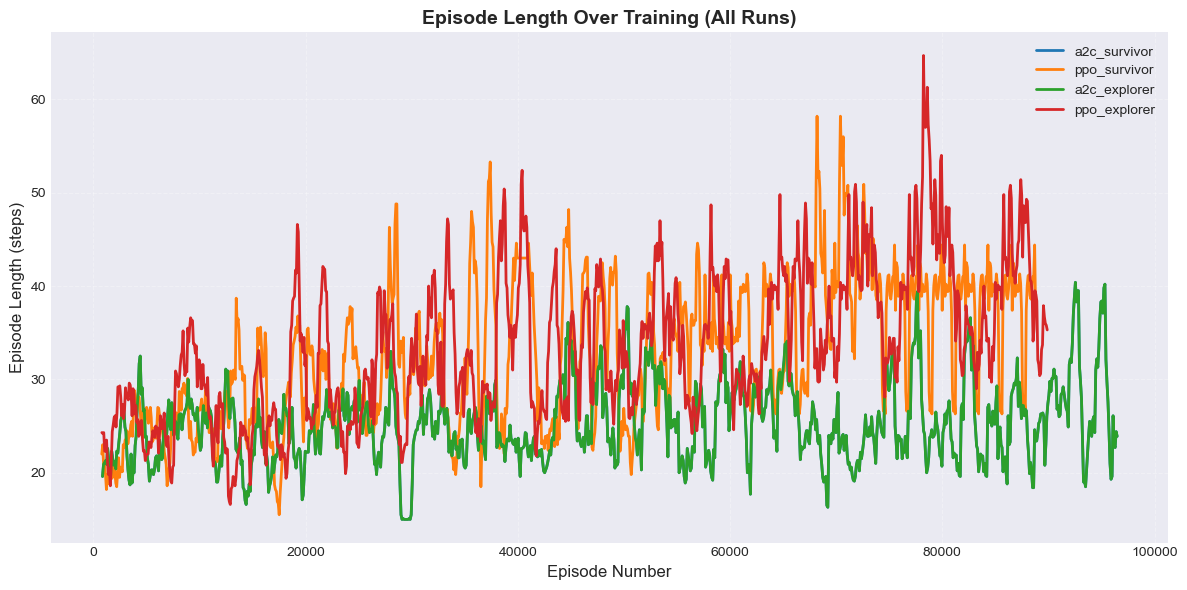

In [25]:
if runs:
    plot_length_curves(runs, use_rolling=True, window=10)
else:
    print('[WARN] Nothing to plot for length curves')


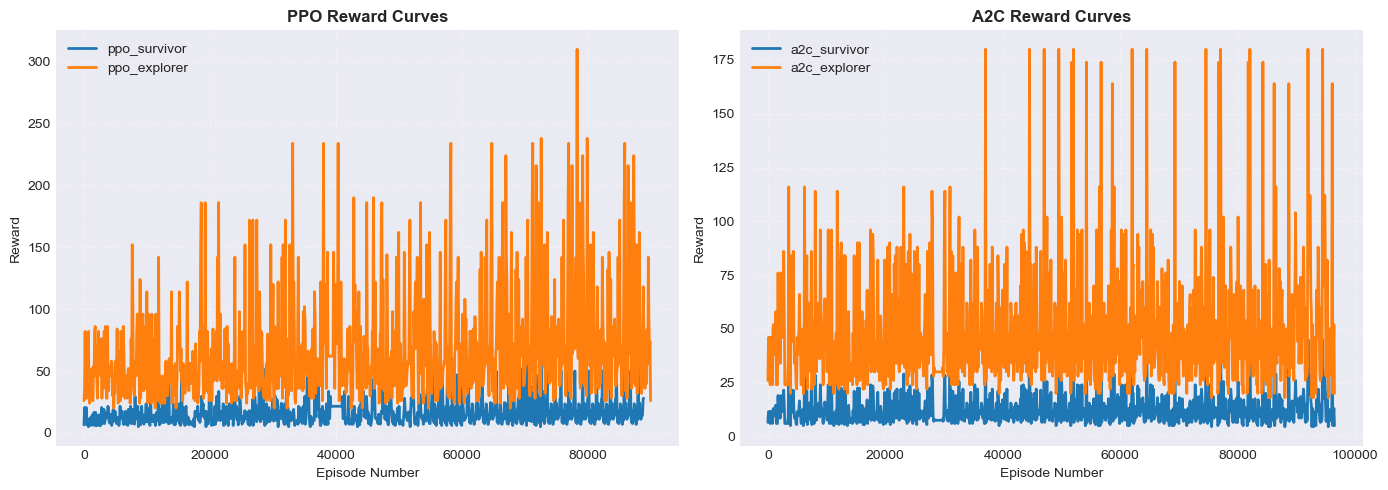

In [26]:
if runs:
    plot_algorithm_comparison(runs)
else:
    print('[WARN] Nothing to plot')


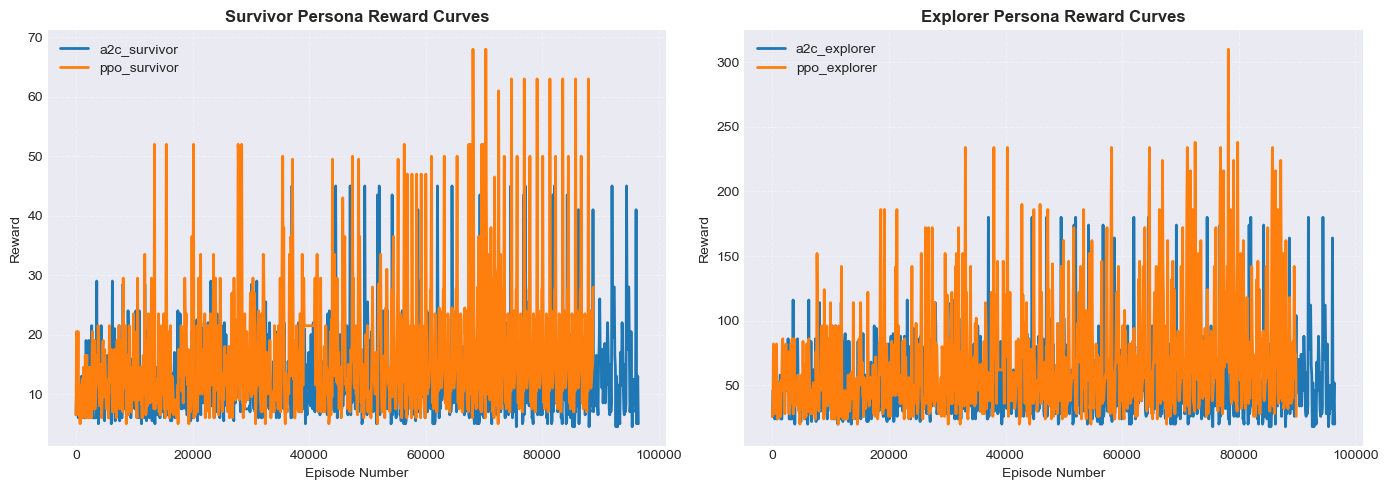

In [27]:
if runs:
    plot_persona_comparison(runs)
else:
    print('[WARN] Nothing to plot')

In [28]:
if len(df_summary) > 0:
    # Show key metrics in a nice format
    key_metrics = df_summary[[
        'run', 'algorithm', 'persona', 
        'total_episodes', 'reward_mean', 'reward_max', 
        'length_mean', 'length_max'
    ]].copy()
    
    # Round numeric columns
    numeric_cols = ['reward_mean', 'reward_max', 'length_mean', 'length_max']
    key_metrics[numeric_cols] = key_metrics[numeric_cols].round(2)
    
    print("\n" + "="*80)
    print("SUMMARY OF ALL TRAINING RUNS")
    print("="*80)
    display(key_metrics)
    
    # Find best performing run
    best_idx = df_summary['reward_mean'].idxmax()
    best_run = df_summary.loc[best_idx]
    print(f"\n🏆 Best performing run: {best_run['run']}")
    print(f"   Algorithm: {best_run['algorithm'].upper()}")
    print(f"   Persona: {best_run['persona'].capitalize()}")
    print(f"   Mean Reward: {best_run['reward_mean']:.2f} ± {best_run['reward_std']:.2f}")
    print(f"   Max Reward: {best_run['reward_max']:.2f}")


SUMMARY OF ALL TRAINING RUNS


,run,algorithm,persona,total_episodes,reward_mean,reward_max,length_mean,length_max
2,a2c_explorer,a2c,explorer,96558,49.81,180.0,24.91,90.0
0,a2c_survivor,a2c,survivor,96558,12.45,45.0,24.91,90.0
3,ppo_explorer,ppo,explorer,89937,67.00,310.0,33.50,155.0
1,ppo_survivor,ppo,survivor,88814,17.07,84.5,34.13,169.0



🏆 Best performing run: ppo_explorer
   Algorithm: PPO
   Persona: Explorer
   Mean Reward: 67.00 ± 44.11
   Max Reward: 310.00
